## Loading and Preparation

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import optuna
from torch.utils.data import DataLoader
from torchinfo import summary

from utils.training import train, optuna_train, best_torch_device
from utils.dataset import EEGDataset

In [3]:
%load_ext autoreload
%autoreload 2

### Select Ideally GPU for Training

In [4]:
device = best_torch_device()
print(device)

mps


### Load Data

In [6]:
X_train = np.load('data/X_train_valid.npy')
y_train = np.load('data/y_train_valid.npy')
X_test = np.load('data/X_test.npy')
y_test = np.load('data/y_test.npy')

split_idx = 1777
X_train, X_valid = X_train[:split_idx], X_train[split_idx:]
y_train, y_valid = y_train[:split_idx], y_train[split_idx:]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1777, 22, 1000)
y_train shape: (1777,)
X_valid shape: (338, 22, 1000)
y_valid shape: (338,)
X_test shape: (443, 22, 1000)
y_test shape: (443,)


In [7]:
train_set = EEGDataset(X_train, y_train, label_smoothing=False)
valid_set = EEGDataset(X_valid, y_valid, label_smoothing=False)
test_set = EEGDataset(X_test, y_test, label_smoothing=False)

In [11]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

## Vision Transformer Model

In [19]:
from models.Transformer import ViTforEEG

raw_model = ViTforEEG().to(device)

summary(raw_model)

Layer (type:depth-idx)                                            Param #
ViTforEEG                                                         64,128
├─Linear: 1-1                                                     1,472
├─TransformerEncoder: 1-2                                         --
│    └─ModuleList: 2-1                                            --
│    │    └─TransformerEncoderLayer: 3-1                          25,216
│    │    └─TransformerEncoderLayer: 3-2                          25,216
├─Sequential: 1-3                                                 --
│    └─Linear: 2-2                                                260
│    └─Softmax: 2-3                                               --
Total params: 116,292
Trainable params: 52,228
Non-trainable params: 64,064

In [20]:
optimizer = torch.optim.Adam(raw_model.parameters(), lr=0.0001, weight_decay=1e-03)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train(
    model=raw_model,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_func=nn.CrossEntropyLoss(),
    train_data=train_loader,
    val_data=valid_loader,
    early_stopping_patience=30,
    cp_path="models/transformer",
    cp_filename="raw.pt",
    n_epochs=200,
    show_progress_bar=False,
)

Using device: mps
[Epoch 0] val_acc=0.245562 train_acc=0.234665 val_loss=0.045132 train_loss=0.043832
Validation loss decreased (inf --> 0.045132).  Saving model ...
[Epoch 1] val_acc=0.245562 train_acc=0.257738 val_loss=0.045117 train_loss=0.043757
Validation loss decreased (0.045132 --> 0.045117).  Saving model ...
[Epoch 2] val_acc=0.260355 train_acc=0.263365 val_loss=0.045096 train_loss=0.043750
Validation loss decreased (0.045117 --> 0.045096).  Saving model ...
[Epoch 3] val_acc=0.278107 train_acc=0.249297 val_loss=0.045066 train_loss=0.043816
Validation loss decreased (0.045096 --> 0.045066).  Saving model ...
[Epoch 4] val_acc=0.269231 train_acc=0.253236 val_loss=0.045018 train_loss=0.043730
Validation loss decreased (0.045066 --> 0.045018).  Saving model ...
[Epoch 5] val_acc=0.254438 train_acc=0.272932 val_loss=0.045119 train_loss=0.043643
EarlyStopping counter: 1 out of 30
[Epoch 6] val_acc=0.260355 train_acc=0.282499 val_loss=0.045072 train_loss=0.043606
EarlyStopping count

KeyboardInterrupt: 

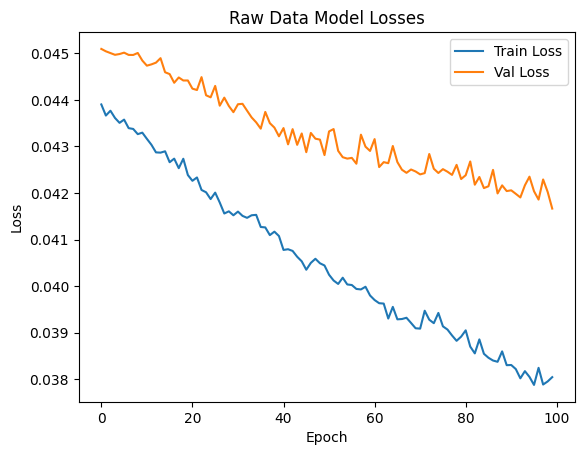

In [14]:
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(val_loss_hist, label="Val Loss")
plt.title("Raw Data Model Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

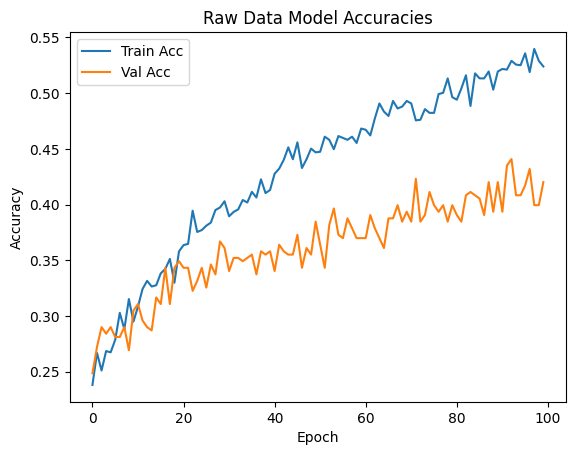

In [15]:
plt.plot(train_acc_hist, label="Train Acc")
plt.plot(val_acc_hist, label="Val Acc")
plt.title("Raw Data Model Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [16]:
# Load best model and test
best_model = torch.load("models/transformer/raw.pt")
best_model.to(device)
best_model.eval()

ViTforEEG(
  (lin_emb): Linear(in_features=22, out_features=64, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=64, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
        (linear2): Linear(in_features=64, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.3, inplace=False)
        (dropout2): Dropout(p=0.3, inplace=False)
      )
    )
  )
  (mlp): Sequential(
    (0): Linear(in_features=64, out_features=4, bias=True)
    (1): Softmax(dim=-1)
  )
)

In [17]:
# Evaluate on raw data
test_acc = 0
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        y_pred = best_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_loader.dataset)
print("Train on raw data, evaluate on raw data")
print(f"Test Acc: {test_acc:.4f}")

Train on raw data, evaluate on raw data
Test Acc: 0.4176


## Model Experimentation

In [23]:
from models.Transformer import ViTforEEG 

new_model = ViTforEEG().to(device)

x = torch.randn(29, 22, 1000)
new_model(x).shape

torch.Size([29, 4])